In [291]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
from fuzzywuzzy import process

In [194]:
movies = 'data/ml-latest/movies.csv'
ratings = 'data/ml-latest/ratings.csv'
tags = 'data/ml-latest/tags.csv'

df_movies = pd.read_csv(movies, usecols=['movieId', 'title'], dtype={'movieId':'int32', 'title':'str'})
df_ratings = pd.read_csv(ratings, usecols=['userId', 'movieId', 'rating'], dtype={'userId':'int32', 'movieId': 'int32', 'rating':'float32'})
df_tags = pd.read_csv(tags, usecols=['userId', 'movieId', 'tag', 'timestamp'], dtype={'userId':'int32', 'movieId': 'int32', 'tag':'str', 'timestamp': 'int32'})

### a) EDA

In [127]:
df_tags.head(10)

,userId,movieId,tag,timestamp
0,10,260,good vs evil,1430666558
1,10,260,Harrison Ford,1430666505
2,10,260,sci-fi,1430666538
3,14,1221,Al Pacino,1311600756
4,14,1221,mafia,1311600746
5,14,58559,Atmospheric,1311530439
6,14,58559,Batman,1311530391
7,14,58559,comic book,1311530398
8,14,58559,dark,1311530428
9,14,58559,Heath Ledger,1311530404


In [ ]:
df_movies.info()
df_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86537 entries, 0 to 86536
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  86537 non-null  int32 
 1   title    86537 non-null  object
dtypes: int32(1), object(1)
memory usage: 1014.2+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33832162 entries, 0 to 33832161
Data columns (total 3 columns):
 #   Column   Dtype  
---  ------   -----  
 0   userId   int32  
 1   movieId  int32  
 2   rating   float32
dtypes: float32(1), int32(2)
memory usage: 387.2 MB


In [ ]:
df_movies.shape

(86537, 2)

In [ ]:
df_movies.head()

,movieId,title
0,1,Toy Story (1995)
1,2,Jumanji (1995)
2,3,Grumpier Old Men (1995)
3,4,Waiting to Exhale (1995)
4,5,Father of the Bride Part II (1995)


In [ ]:
df_ratings.head(10)

,userId,movieId,rating
0,1,1,4.0
1,1,110,4.0
2,1,158,4.0
3,1,260,4.5
4,1,356,5.0
5,1,381,3.5
6,1,596,4.0
7,1,1036,5.0
8,1,1049,3.0
9,1,1066,4.0


In [ ]:
num_movies = df_movies.shape
num_ratings = df_ratings.shape
print(f'\nTotal number of movies and columns: {num_movies}')
print(f'Total number of ratings and columns: {num_ratings}')


Total number of movies and columns: (86537, 2)
Total number of ratings and columns: (33832162, 3)


### b) De 10 filmer med flest ratings

In [223]:
# Beräknar antalet betyg per film
ratings_count = df_ratings['movieId'].value_counts().reset_index()
ratings_count.columns = ['movieId', 'num_of_ratings']

# Sorterar filmerna efter antalet betyg
sorted_movies = ratings_count.sort_values(by='num_of_ratings', ascending=False)

# De 10 filmerna med flest betyg
top_10_movies = sorted_movies.head(10)

# Slår ihop top_10_movies med df_movies för att få titlarna
top_10_movie_title = pd.merge(top_10_movies, df_movies, on='movieId')

print('Top 10 Movies with Most Ratings')
print(top_10_movie_title[['movieId', 'title', 'num_of_ratings']].to_string(index=False))


Top 10 Movies with Most Ratings
 movieId                                                 title  num_of_ratings
     318                      Shawshank Redemption, The (1994)          122296
     356                                   Forrest Gump (1994)          113581
     296                                   Pulp Fiction (1994)          108756
    2571                                    Matrix, The (1999)          107056
     593                      Silence of the Lambs, The (1991)          101802
     260             Star Wars: Episode IV - A New Hope (1977)           97202
    2959                                     Fight Club (1999)           86207
     527                               Schindler's List (1993)           84232
     480                                  Jurassic Park (1993)           83026
    1196 Star Wars: Episode V - The Empire Strikes Back (1980)           80200


### c) Genomsnittliga ratingen för de 10 filmerna med flest ratings

In [232]:
# 10 filmer med flest betyg
top_10_movies = df_ratings['movieId'].value_counts().head(10).index

# Filtrerar betygen för de 10 filmerna med flest betyg
ratings_top_10 = df_ratings[df_ratings['movieId'].isin(top_10_movies)]

# Beräknar genomsnittligt betyg för varje film
average_ratings_top_10 = ratings_top_10.groupby('movieId')['rating'].mean().reset_index(name='avg_rating')

# Slår ihop top_10_movies med df_movies för att få titlarna
top_10_movie_title = pd.merge(average_ratings_top_10, df_movies, on='movieId')

# Sortera top_10_movie_title efter avg_rating i avtagande ordning
top_10_movie_title_sorted = top_10_movie_title.sort_values(by='avg_rating', ascending=False)

print('Average Ratings for Top 10 Movies')
print(top_10_movie_title_sorted[['movieId', 'title', 'avg_rating']].to_string(index=False))

Average Ratings for Top 10 Movies
 movieId                                                 title  avg_rating
     318                      Shawshank Redemption, The (1994)    4.416792
     527                               Schindler's List (1993)    4.242337
    2959                                     Fight Club (1999)    4.236019
     296                                   Pulp Fiction (1994)    4.191778
    2571                                    Matrix, The (1999)    4.160631
     593                      Silence of the Lambs, The (1991)    4.150287
    1196 Star Wars: Episode V - The Empire Strikes Back (1980)    4.118030
     260             Star Wars: Episode IV - A New Hope (1977)    4.092401
     356                                   Forrest Gump (1994)    4.068189
     480                                  Jurassic Park (1993)    3.689013


### d) Plot över årtal och antalet filmer

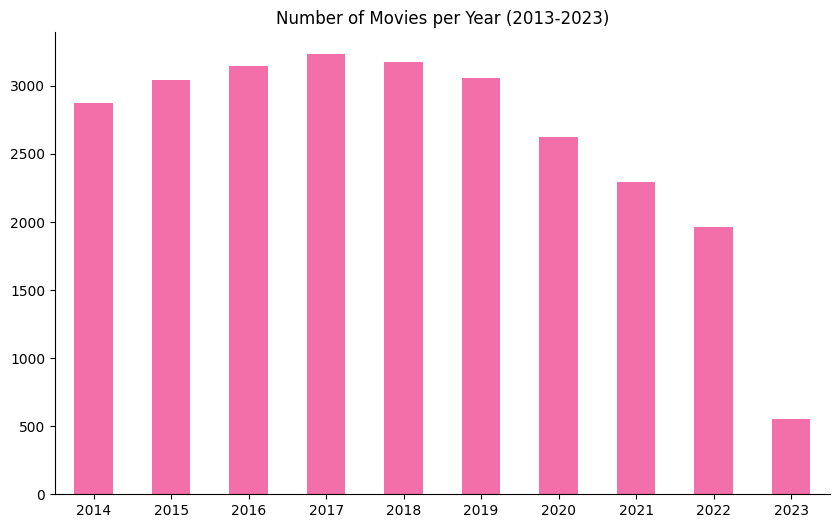

In [225]:
# Extraherar år från titeln: (r'\((\d{4})\)') tar 4 siffror inom parentes, i detta fall år
df_movies['year'] = df_movies['title'].str.extract(r'\((\d{4})\)')

# Konverterar året till numeriskt format
df_movies['year'] = df_movies['year'].apply(lambda x: pd.to_numeric(x, errors='coerce')).astype('Int32')

# Filtrerar ut filmer mellan 2014 och 2023
df_movies_filtered = df_movies[(df_movies['year'] >= 2014) & (df_movies['year'] <= 2023)]

# Grupperar och beräknar antalet filmer per år
movies_per_year_filtered = df_movies_filtered.groupby('year').size()

# Sorterar resultatet i fallande ordning och tar de sista 10 åren
movies_per_year_filtered_sorted = movies_per_year_filtered.sort_index(ascending=True).head(11)

fig, ax = plt.subplots(figsize=(10, 6))
movies_per_year_filtered_sorted.plot(kind='bar', color='#F26FA9', ax=ax)
ax.set_title('Number of Movies per Year (2013-2023)')
ax.set_xlabel('')
ax.tick_params(axis='x', rotation=0)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.show()


### e) Plot över antalet ratings mot movieId

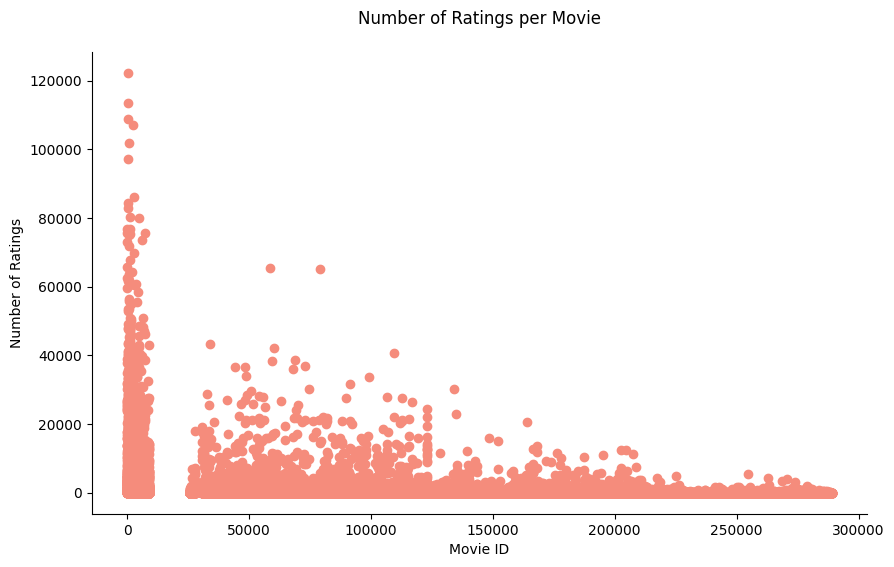

In [226]:
# Antalet betyg per film
ratings_per_movie = df_ratings.groupby('movieId').size()

fig, ax = plt.subplots(figsize=(10, 6))
# Plottar antalet betyg mot movieId
ax.plot(ratings_per_movie.index, ratings_per_movie.values, marker='o', linestyle='', color='#F58C7C')
ax.set_title('Number of Ratings per Movie', pad=20)
ax.set_xlabel('Movie ID')
ax.set_ylabel('Number of Ratings')
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.show()


### f) Genomsnittliga ratings för de top 10 filmerna med flest ratings

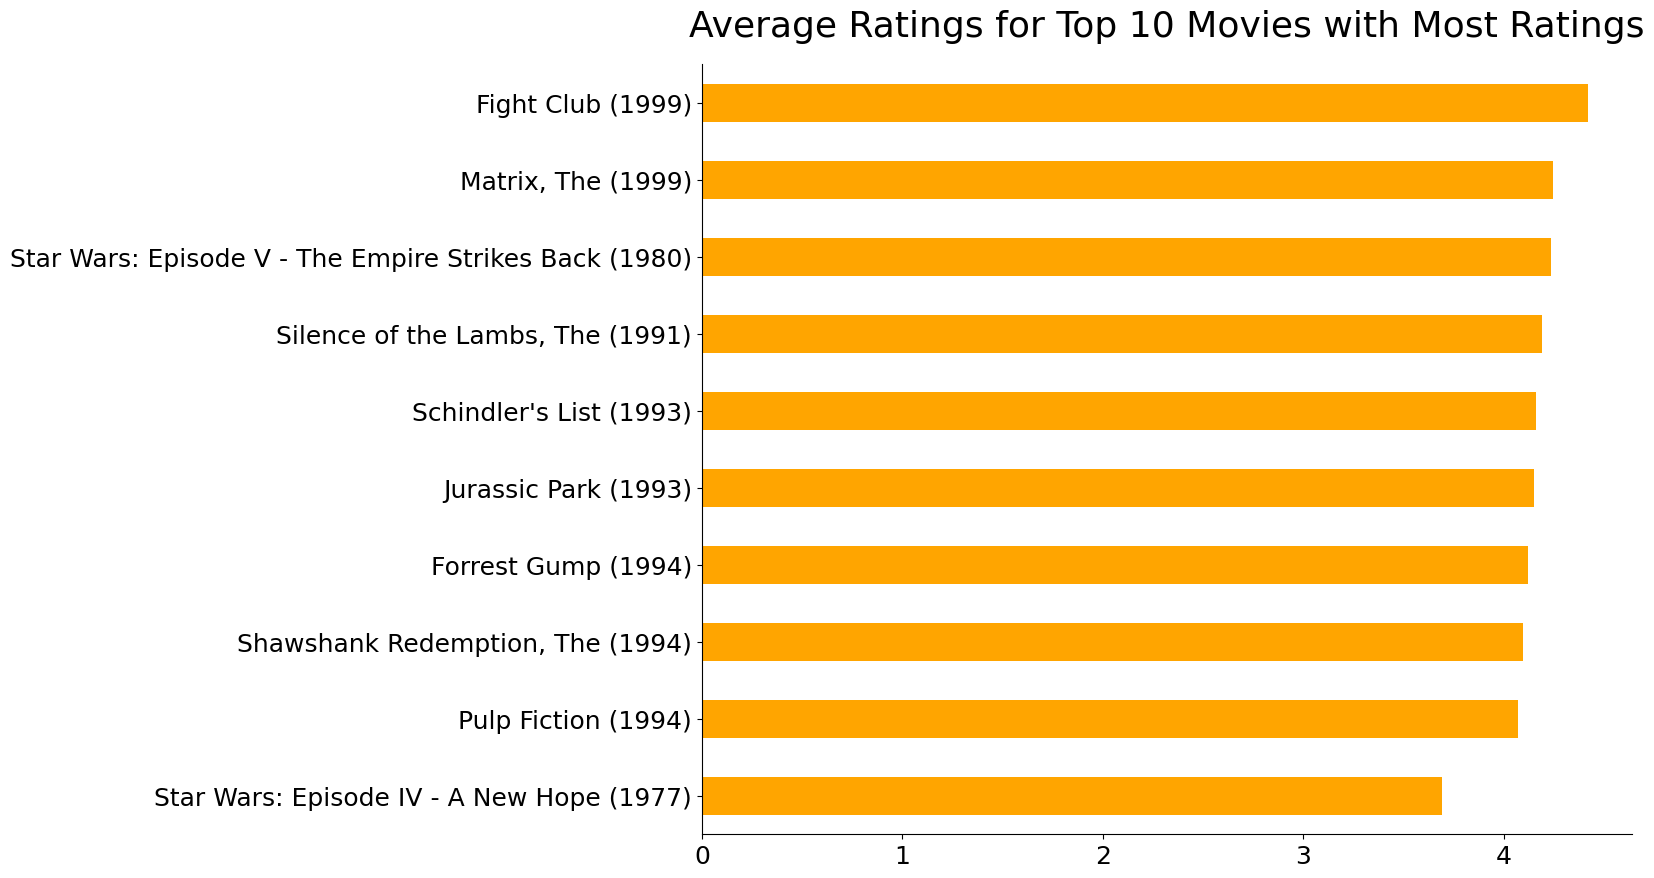

In [ ]:
# 10 filmer med flest betyg
top_10_movies = df_ratings['movieId'].value_counts().head(10).index

# Filtrerar betyg för de 10 filmer med flest betyg
ratings_top_10 = df_ratings[df_ratings['movieId'].isin(top_10_movies)]

# Beräknar genomsnittligt betyg för varje film
average_ratings_top_10 = ratings_top_10.groupby('movieId')['rating'].mean()

# Hämtar titlar för de 10 filmer med flest betyg
movie_titles = df_movies[df_movies['movieId'].isin(top_10_movies)].set_index('movieId')['title']

# Sortera betygen i stigande ordning
average_ratings_top_10_sorted = average_ratings_top_10.sort_values(ascending=True)

# Använder filmernas titlar som index för average_ratings_top_10_sorted
average_ratings_top_10_sorted.index = movie_titles

# Plottar med liggande staplar
fig, ax = plt.subplots(figsize=(12, 10))
average_ratings_top_10_sorted.plot(kind='barh', color='orange')
ax.set_title('Average Ratings for Top 10 Movies with Most Ratings', pad=20, font=dict(size=26), loc='center')
ax.set_ylabel('')
ax.tick_params(axis='both', which='major', labelsize=18)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.show()


## 1.2

In [293]:
'''
# Först, fyll NaN-värden med ''ND'' sträng i kolumnen 'tag'
df_tags_filled = df_tags.fillna({'tag': 'ND'})

# Skapa en ny DataFrame för betyg för filmer som tillhör den specifika genren
df_filtered_genre = df_ratings[df_ratings['movieId'].isin(df_movies['movieId'])]

# Filtrerar ut användare och filmer baserat på antal betyg som getts och mottagits
min_user_ratings = 100
min_movie_ratings = 1000
genre_tag = 'action', 'drama'

# Antalet betyg per användare och film
user_counts = df_ratings['userId'].value_counts()
movie_counts = df_ratings['movieId'].value_counts()

# Filtrerar användare och filmer baserat på antal betyg
filtered_users = user_counts[user_counts >= min_user_ratings].index
filtered_movies = movie_counts[movie_counts >= min_movie_ratings].index

# Fyller NaN-värden med en tom sträng i kolumnen 'tag'
df_tags_filled = df_tags.fillna({'tag': ''})

# Filtrerar taggar baserat på genre
filtered_tags = df_tags_filled[df_tags_filled['tag'].str.contains('|'.join(genre_tag), case=False)]

# Filtrerar DataFramen för att bara behålla betyg från dessa användare, filmer och taggar
df_filtered = df_ratings[(df_ratings['userId'].isin(filtered_users)) & 
                         (df_ratings['movieId'].isin(filtered_movies)) & 
                         (df_ratings['movieId'].isin(filtered_tags['movieId']))]

# Betyg baserat på användare och filmer
min_rating = 3
max_rating = 5
df_filtered = df_filtered[(df_filtered['rating'] >= min_rating) & (df_filtered['rating'] <= max_rating)]

# Använder alternativa betygsformat ( i detta fall binära betyg)
df_filtered['binary_rating'] = (df_filtered['rating'] > 3).astype(int)

# Skapar en gles matris från den filtrerade DataFramen
sparse_matrix = csr_matrix((df_filtered['rating'], (df_filtered['movieId'], df_filtered['userId'])))

# Resultatet blir en gles matris där varje rad representerar en film och varje kolumn representerar en användare,
# och varje cell innehåller betyget som användaren har gett filmen
'''

In [294]:
# Fyller NaN-värden med ''ND'' i kolumnen 'tag'
df_tags_filled = df_tags.fillna({'tag': 'ND'})

# Skapar en ny DataFrame för betyg för filmer som tillhör en specifik genre
df_filtered_genre = df_ratings[df_ratings['movieId'].isin(df_movies['movieId'])]

In [319]:
# Skapar en CSR-matris för att representera användare- och film-betyg
def sparse_matrix(df):
    # Räknar antalet unika användare och filmer (N och M)
    # N = längden på listan av unika användar-ID i DataFrame df['userId']
    # M = längden på listan av unika film-ID i DataFrame df['movieId']
    N = len(df['userId'].unique())
    M = len(df['movieId'].unique())


    # Mappning från ID till index (user_mapper och movie_mapper)

    # list(range(N/M)) skapar en lista med index från 0 till N-1.
    # dict(zip(...)) skapar en dictionary där varje unikt ID matchas med motsvarande index.

    # Mappar Ids till indices
    user_map = dict(zip(np.unique(df["userId"]), list(range(N)))) #returnerar en lista med unika användar-ID i DataFrame df["userId"]
    movie_map = dict(zip(np.unique(df["movieId"]), list(range(M)))) #returnerar en lista med unika film-ID i DataFrame df["movieId"]


    # Mappar från index till ID (user_inv_mapper och movie_inv_mapper)

    # Samma som ovan,fast med index som nycklar och ID som värden.
    # Mappar indices till Ids
    user_invert_map = dict(zip(list(range(N)), np.unique(df["userId"])))
    movie_invert_map = dict(zip(list(range(M)), np.unique(df["movieId"])))

    # Skapar index för användare och filmer i DataFrame df(user_index och movie_index)

    #     user_index är en lista med användarindex i DataFrame df baserat på user_mapper
    #     movie_index är en lista med filmindex i DataFrame df baserat på movie_mapper
    user_index = [user_map[i] for i in df['userId']]
    movie_index = [movie_map[i] for i in df['movieId']]

    # Skapar en CSR-matris(X) för användare- och film-betyg

    # en lista med betyg
    # row_indices är en lista med radindex för betyg
    # col_indices är en lista med kolumnindex för betygen
    # shape=(M, N) anger dimensionerna på den resulterande matrisen där M är antalet rader (filmer) och N är antalet kolumner (användare)

    X = csr_matrix((df["rating"], (movie_index, user_index)), shape=(M, N)) # skapar en komprimerad sparad rad (CSR) matris från betyg (data) med tillhörande rad- och kolumnindex

    # Returnerar matrisen X som representerar användare- och film-betyg, samt de fyra mappningarna: user_mapper, movie_mapper, user_inv_mapper, och movie_inv_mapper, som kan användas för att översätta mellan ID och index.

    return X, user_map, movie_map, user_invert_map, movie_invert_map

X, user_map, movie_map, user_invert_map, movie_invert_map = sparse_matrix(df_filtered_genre)



## 1.3

In [313]:
model_knn = NearestNeighbors(metric="cosine", algorithm="brute", n_neighbors=2)

In [314]:
model_knn.fit(X) # Här använder vi redan .fit

NearestNeighbors(algorithm='brute', metric='cosine', n_neighbors=2)

In [308]:
def recommender_genre(movie_name, model, n_recommendations):
    match = process.extractOne(movie_name, df_tags_filled["tag"])
    if match is not None:
        idx = match[2]
        print("Movie Selected: ", df_tags_filled["tag"].iloc[idx], "Index: ", idx)
        print("Searching for recommendations....")

        distances, indices = model.kneighbors(X[idx], n_neighbors=n_recommendations)
        for i in range(len(indices)):
            if np.any(indices[i] != idx) and 0 <= indices[i] < len(df_tags_filled):  # Kontroll för att undvika ogiltiga index
                print(df_tags_filled["tag"].iloc[indices[i]])
                #print(df_movies["title"][i].where(i!=idx))

            else:
                print("Invalid index:", indices[i])
        else:
            print("Movie not found:", movie_name)

# Använd funktionen för att göra rekommendationer för en specifik film inom den valda genren
recommender_genre('toy story', model_knn, 20)


Movie Selected:  Toy Story Index:  13136
Searching for recommendations....


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [317]:
# Hitta liknande filmer med hjälp av KNN
def find_similar_movies(movie_title, X, k, metric='cosine', show_distance=False):
    neighbour_ids = []

    # söker efter den närmaste matchande filmtiteln för den användarvalda titeln med hjälp av FuzzyWuzzy
    movie_match = process.extractOne(movie_title, df_movies["title"]) 
    # Om en matchning hittas, returneras en tuple med matchande titel, matchpoäng och index för den matchande titeln
    
    # Om en matchning hittas, hämtas den matchande titeln, 'matchpoängen' och index från tupeln
    # Filmens id hämtas från DataFrame df_movies med hjälp av index, och sen lagras filmens id i variabeln selected_movie_id

    if movie_match is not None:
        matched_title, score, idx = movie_match
        print(f"Closest match: {matched_title} (Score: {score})")
        selected_movie_id = df_movies.loc[idx, 'movieId']
        print(f"Selected movieId: {selected_movie_id}")

        # Beräkna index för den matchande filmen i CSR-matrisen (movie_ind)
        # används för att översätta filmens id till dess motsvarande index i CSR-matrisen
        movie_ind = movie_map[selected_movie_id]
        movie_vec = X[movie_ind]

        # KNN används för att hitta liknande filmer

        # Instans av NearestNeighbors skapas med antalet grannar 'k' och metric
        # CSR-matrisen X anpassas till fit()-metoden för att träna modellen


        k += 1
        kNN = NearestNeighbors(n_neighbors=k, algorithm="brute", metric=metric)
        kNN.fit(X)
        
        movie_vec = movie_vec.reshape(1, -1)
        # .kneighbours används för att hitta de närmaste k grannarna till den matchande filmen
        # Den matchande filmens vektor (movie_vec) hämtas från matrisen
        # Om show_distance (i konstruktorn) är satt till True, returnerasavståndet mellan den matchande filmen och dess grannar
        neighbour = kNN.kneighbors(movie_vec, return_distance=show_distance)

    #     Översätt index för grannarna till film-id (neighbour_ids)

        # Indexen för grannarna returneras från kneighbors-funktionen
        # Dessa indexen översätts sen till film-id med hjälp av mappningen movie_invert_map
        # De 'översatta' film-iderna lagras i listan neighbour_ids.

        for i in range(0, k):
            n = neighbour.item(i)
            neighbour_ids.append(movie_invert_map[n])
        neighbour_ids.pop(0)
    else:
        print("Movie not found.")

    # Om en matchning hittas, returneras listan neighbour_ids som innehåller id för de liknande filmerna
    # Om ingen matchning hittades, returneras en tom lista
    return neighbour_ids


# Användaren får mata in en filmtitel
selected_movie_title = input("Vilken film vill du söka på? ")

# Hittar liknande filmer baserat på användarens input
similar_movie_ids = find_similar_movies(selected_movie_title, X, k=10)
print(f"Since you watched {selected_movie_title}:")
for movie_id in similar_movie_ids:
    print(movie_titles[movie_id])


Closest match: Toy Story (1995) (Score: 90)
Selected movieId: 1
Since you watched toy story:
Toy Story 2 (1999)
Star Wars: Episode IV - A New Hope (1977)
Independence Day (a.k.a. ID4) (1996)
Back to the Future (1985)
Jurassic Park (1993)
Lion King, The (1994)
Forrest Gump (1994)
Aladdin (1992)
Star Wars: Episode VI - Return of the Jedi (1983)
Monsters, Inc. (2001)


# https://www.geeksforgeeks.org/recommendation-system-in-python/

In [260]:
   
n_ratings = len(df_ratings)
n_movies = len(df_ratings['movieId'].unique())
n_users = len(df_ratings['userId'].unique())

print(f"Number of ratings: {n_ratings}")
print(f"Number of unique movieId's: {n_movies}")
print(f"Number of unique users: {n_users}")
print(f"Average ratings per user: {round(n_ratings/n_users, 2)}")
print(f"Average ratings per movie: {round(n_ratings/n_movies, 2)}")

Number of ratings: 33832162
Number of unique movieId's: 83239
Number of unique users: 330975
Average ratings per user: 102.22
Average ratings per movie: 406.45


In [262]:
   
user_freq = df_ratings[['userId', 'movieId']].groupby(
    'userId').count().reset_index()
user_freq.columns = ['userId', 'n_ratings']
print(user_freq.head())

   userId  n_ratings
0       1         62
1       2         91
2       3         30
3       4         30
4       5         43


In [265]:
# Find Lowest and Highest rated movies:
mean_rating = df_ratings.groupby('movieId')[['rating']].mean()
# Lowest rated movies
lowest_rated = mean_rating['rating'].idxmin()
df_movies.loc[df_movies['movieId'] == lowest_rated]
# Highest rated movies
highest_rated = mean_rating['rating'].idxmax()
df_movies.loc[df_movies['movieId'] == highest_rated]
# show number of people who rated movies rated movie highest
df_ratings[df_ratings['movieId']==highest_rated]
# show number of people who rated movies rated movie lowest
df_ratings[df_ratings['movieId']==lowest_rated]

## the above movies has very low dataset. We will use bayesian average
movie_stats = df_ratings.groupby('movieId')[['rating']].agg(['count', 'mean'])
movie_stats.columns = movie_stats.columns.droplevel()


In [268]:
# Now, we create user-item matrix using scipy csr matrix
from scipy.sparse import csr_matrix

def create_matrix(df):
	
	N = len(df['userId'].unique())
	M = len(df['movieId'].unique())
	
	# Map Ids to indices
	user_mapper = dict(zip(np.unique(df["userId"]), list(range(N))))
	movie_mapper = dict(zip(np.unique(df["movieId"]), list(range(M))))
	
	# Map indices to IDs
	user_inv_mapper = dict(zip(list(range(N)), np.unique(df["userId"])))
	movie_inv_mapper = dict(zip(list(range(M)), np.unique(df["movieId"])))
	
	user_index = [user_mapper[i] for i in df['userId']]
	movie_index = [movie_mapper[i] for i in df['movieId']]

	X = csr_matrix((df["rating"], (movie_index, user_index)), shape=(M, N))
	
	return X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper
	
X, user_map, movie_map, user_invert_map, movie_invert_map = create_matrix(df_ratings)


In [277]:
"""
Find similar movies using KNN
"""
def find_similar_movies(movie_id, X, k, metric='cosine', show_distance=False):
	
	neighbour_ids = []
	
	movie_ind = movie_map[movie_id]
	movie_vec = X[movie_ind]
	k+=1
	kNN = NearestNeighbors(n_neighbors=k, algorithm="brute", metric=metric)
	kNN.fit(X)
	movie_vec = movie_vec.reshape(1,-1)
	neighbour = kNN.kneighbors(movie_vec, return_distance=show_distance)
	for i in range(0,k):
		n = neighbour.item(i)
		neighbour_ids.append(movie_invert_map[n])
	neighbour_ids.pop(0)
	return neighbour_ids


movie_titles = dict(zip(df_movies['movieId'], df_movies['title']))

movie_id = 450

similar_ids = find_similar_movies(movie_id, X, k=10)
movie_title = movie_titles[movie_id]

print(f"Since you watched {movie_title}")
for i in similar_ids:
	print(movie_titles[i])


Since you watched With Honors (1994)
Renaissance Man (1994)
Son in Law (1993)
It Could Happen to You (1994)
Speechless (1994)
Man Without a Face, The (1993)
Higher Learning (1995)
Paper, The (1994)
Threesome (1994)
Made in America (1993)
I Love Trouble (1994)
